In [1]:
import os
import pandas as pd
import re
import openpyxl

# Dossier contenant les fichiers CSV
csv_folder = '../data/international_TES'

# Lister tous les fichiers CSV dans le dossier
csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]
 
# Dictionnaire pour stocker les DataFrames
dfs = {}

for csv_file in csv_files:
    file_path = os.path.join(csv_folder, csv_file)
    # Prendre uniqument les nombres de 'csv_file'
    year = re.sub(r'\D', '', csv_file)
    df = pd.read_csv(file_path)
    dfs[year] = df

df_pays = pd.read_excel(
    "../data/international_TES/ReadMe_ICIO_small.xlsx",
    sheet_name="Area_Activities",
    header=2,      # L'en-tête ("Code") est bien à la ligne 3 (index 2)
    usecols='C'    # ON NE LIT QUE LA COLONNE C
)
df_pays.rename(columns={'Code': 'Pays'})

g:\Mon Drive\TES\tes_env\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: ColItems!$A:$A.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
g:\Mon Drive\TES\tes_env\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: RowItems!$A:$A.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Pays
0,ARG
1,AUS
2,AUT
3,BEL
4,BGD
...,...
86,NaN
87,NaN
88,NaN
89,NaN


In [2]:
# Nettoyage des noms de colonnes (suppression des 4 premiers caractères) et de la première colonne (sauf 3 dernières lignes)
df_clean = {}
for year, df in dfs.items():
    # Nettoyage des colonnes
    new_cols = [col[4:] if len(col) > 4 else col for col in df.columns]
    df_clean[year] = df.copy()
    df_clean[year].columns = new_cols

    # Nettoyage de la première colonne (sauf 3 dernières lignes)
    if df_clean[year].shape[0] > 3:
        main_rows = df_clean[year].iloc[:-3, 0].apply(lambda x: x[4:] if isinstance(x, str) and len(x) > 4 else x)
        last_rows = df_clean[year].iloc[-3:, 0]
        df_clean[year].iloc[:-3, 0] = main_rows
        df_clean[year].iloc[-3:, 0] = last_rows
        df_clean[year].set_index("V1", inplace=True)

In [3]:
# Somme des colonnes et des lignes ayant le même nom dans chaque DataFrame de df_clean

df_sum = {}
for year, df in df_clean.items():
    # Somme des colonnes ayant le même nom
    df_cols_summed = df.groupby(df.columns, axis=1).sum()
    # Somme des lignes ayant le même nom (index)
    df_rows_summed = df_cols_summed.groupby(df_cols_summed.index).sum()
    df_sum[year] = df_rows_summed

C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\3954505384.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_cols_summed = df.groupby(df.columns, axis=1).sum()
C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\3954505384.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_cols_summed = df.groupby(df.columns, axis=1).sum()
C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\3954505384.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_cols_summed = df.groupby(df.columns, axis=1).sum()
C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\3954505384.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_cols_summed = df.groupby(df.columns, axis=1).sum()
C:\Users\gaetan.blec

In [4]:
descp_nace = pd.read_excel("../data/NACE 38 - 88 detaille vf.xlsx")
# On rempli les celluls qui n'ont pas été remplies à cause de la fusion des cellules
descp_nace.fillna(method='ffill', inplace=True)

C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\2535090936.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  descp_nace.fillna(method='ffill', inplace=True)


In [5]:
# Agrégation des DataFrames de df_sum de NACE 88 vers NACE 17
df_sum_nace17 = {}
# Créer un mapping NACE 88 -> NACE 17 à partir de descp_nace
nace88_to_17 = descp_nace.set_index('Nace 88')['NACE 17'].to_dict()

for year, df in df_sum.items():
    # Remplacer les noms de colonnes par leur NACE 17
    new_cols = [nace88_to_17.get(col, col) for col in df.columns]
    df_nace17 = df.copy()
    df_nace17.columns = new_cols
    # Remplacer les indices par leur NACE 17
    new_idx = [nace88_to_17.get(idx, idx) for idx in df_nace17.index]
    df_nace17.index = new_idx
    # Grouper et sommer par NACE 17 (colonnes et lignes)
    df_nace17 = df_nace17.groupby(df_nace17.index).sum()
    df_nace17 = df_nace17.groupby(axis=1, level=0).sum()
    df_sum_nace17[year] = df_nace17


C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\1936489676.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_nace17 = df_nace17.groupby(axis=1, level=0).sum()
C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\1936489676.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_nace17 = df_nace17.groupby(axis=1, level=0).sum()
C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\1936489676.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_nace17 = df_nace17.groupby(axis=1, level=0).sum()
C:\Users\gaetan.blecon_square\AppData\Local\Temp\ipykernel_4756\1936489676.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_nace17 = df_nace17.groupby(axis=1, level=0).sum()
C:\Users\gaetan.blec

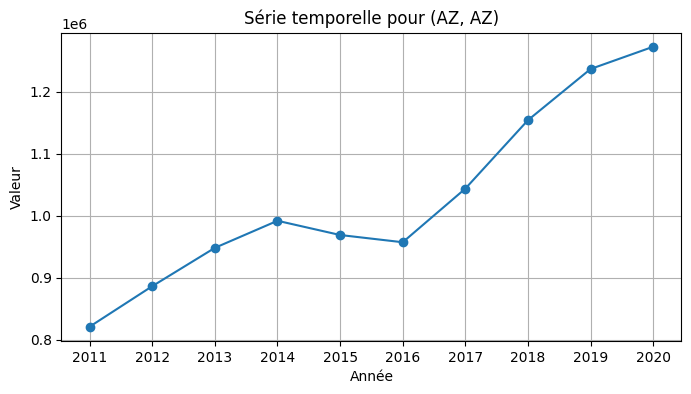

In [6]:
import matplotlib.pyplot as plt

def plot_time_series(row, col, df_dict):
    """
    Trace la série temporelle pour une combinaison (ligne, colonne) à partir de df_sum_nace17.
    Args:
        row (str): nom de la ligne (secteur NACE 17)
        col (str): nom de la colonne (secteur NACE 17)
        df_dict (dict): dictionnaire d'années -> DataFrame (ici df_sum_nace17)
    """
    years = sorted(df_dict.keys())
    values = []
    for year in years:
        df = df_dict[year]
        try:
            values.append(df.loc[row, col])
        except KeyError:
            values.append(float('nan'))
    plt.figure(figsize=(8,4))
    plt.plot(years, values, marker='o')
    plt.title(f"Série temporelle pour ({row}, {col})")
    plt.xlabel("Année")
    plt.ylabel("Valeur")
    plt.grid(True)
    plt.show()

# Exemple d'utilisation :
plot_time_series('AZ', 'AZ', df_sum_nace17)

Zt cyclique : C2, C3, C5, CH, FZ, GZ, HZ, IZ

Zt Défensifs : AZ, C1, DZ, MN, OQ, RU

Zt Taux d'Intérêt : JZ, KZ, LZ

Zt Matières Premières : BZ, C2, CH, DZ

Ce regroupement n'est plus réelment valable, ca n'a plus vraiment de sens de comprender les intéractions entre des regroupemnts de secteurs basés sur leur dépendance à des variables macro. On aimerait avoir des regroupements purement sectoriels en fonction du rapprochement des activités. 

Je vais essayer de repartir sur un bonne base et de revenir sur la création de la base en mode clean en recompilant les codes et en mettant les bonnes étiquettes au bon endroit. 
Surement créer un git avec un branchement plus intelligent.

La branche main cntiendra les fichiers importants quil faudra transporter tout le long du projet, ensuite on feras des branchements spécifiques pour faire les différentes opérations nécessaires. 

La première banche sera l'enrichissement de la base : ajout de pays et secteur. On met "à jour" la base de données avec les nouveaux éléments.

La seconde branche va être dédiée au calcul des facteurs systémiques. On pourra faire un premeir sous branchemnt destiné au regroupent sectoriel comme j'ai essayé de faire. Le second sous-branchement aura pour objectif de créer les Zt les plus grnaluaires possibles, on va tenter de définir le nombre de cotations nécessaires minimales par période pour garantir une significativité raisonnable.

La 3ème branche sera destinée aux modèles satellites. On verra com^ment arboriser plus tard.